Задание **Ultra pro**

Добейтесь точности не менее 85% на проверочной выборке на базе трех иномарок. 

Размер проверочной выборки - 20%.

In [ ]:
# Для начала импортируем все необходимые для создания нейронной сети библиотеки.

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import math
import os
from google.colab import drive
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import random

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Так как нужно добиться определенного результата, то в работе будут примеры нейронных сетей, у которых показатель val_accuracy на проверочной выборке больше 0.85**.

  Но чтобы добиться такого результата было перепробовано очень много разных варинатов:
  - Изменение кол-ва различных слоев
  - Изменения кол-ва нейронов
  - Активационных функций
  - Функции ошибки
  - И тп.


# Подготовка данных 

Нейронная сеть показывала разный результат в зависимости от параметров ширины и высоты изображения. Слишком маленькие параметры или наоборот слишком большое кол-во пикселей в картинке ухудшали реультат. 
   Лучший результат из всех вариантов, которые я перебрал показали изображения с шириной 192 и высотой 108

In [ ]:
# Загрузим все картинки в переменную 
train_path = '/content/drive/MyDrive/Cars' 

# Зададим параметры картинок. Ширину и высоту
img_width = 192 
img_height = 108 

**В задании сказано  - Размер проверочной выборки - 20%**.

**Поэтому зададим параметр validation_split равным 0.2**. 

In [ ]:
# С помощью генератора изображений изменим изображения (так как очень маленькая база для обучения)
datagen = ImageDataGenerator(
    rescale=1. / 255,        # Цвет
    rotation_range=10,       # Поворот
    width_shift_range=0.15,  # Сдвиг по ширине
    height_shift_range=0.15, # Сдвиг по высоте
    zoom_range=0.15,         # Зум
    horizontal_flip=True     # Горизонтальное отзеркаливание 
    fill_mode='nearest',     # Заполнение пикселями после сдвига
    validation_split=0.2     # Разделение на обучающую и проверочную выборки
)

In [ ]:
# Зададим размер batch_size
batch_size =  25 

In [ ]:
# Зададим две выборки

# обучающая выборка

train_generator = datagen.flow_from_directory(
    train_path,                                   # Это путь с папками (Ferrari, Mersedes, Reno)
    target_size=(img_width, img_height),          # Зададим размер исходя из параметров которые определили ранее
    batch_size=batch_size,                        # Зададим batch_size
    class_mode='categorical',                     #Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True,                                 #Перемешивание выборки (не обязательно, можно и без него. Картинки и так перемешаны)
    subset='training'                             # Устанавливаем train_generator как набор для обучения
)

# Проверочная выборка. Аналогично как с обучающей. 

validation_generator = datagen.flow_from_directory(
    train_path, 
    target_size=(img_width, img_height),
    batch_size=batch_size, 
    class_mode='categorical',  
    shuffle=True, 
    subset='validation' 
)

Found 2743 images belonging to 3 classes.
Found 684 images belonging to 3 classes.


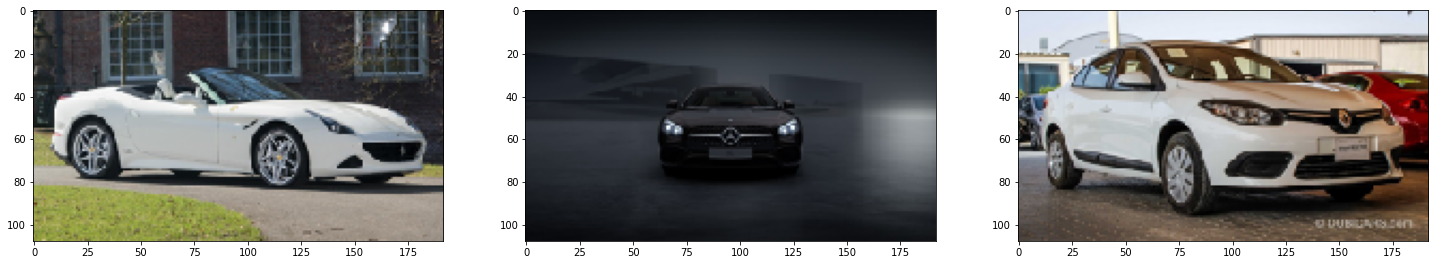

In [ ]:
# Для примера можно вывести картинки. Можно заметить что после увеличения значений img_width и img_height, картинки стали более лучшего качества.

fig, axs = plt.subplots(1, 3, figsize=(25, 5)) 
for i in range(3): 
  car_path = train_path + '/' + os.listdir(train_path)[i] + '/'
  img_path = car_path + random.choice(os.listdir(car_path)) 
  axs[i].imshow(image.load_img(img_path, target_size=(img_height, img_width)))

plt.show() 

In [ ]:
#Создаем нейронную сеть и первый раз обучаем с шагом lr(learning rate) = 0.001
model = Sequential()

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(img_width, img_height, 3)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))


model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(2048, activation='relu'))

model.add(Dense(4096, activation='relu'))

model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [ ]:
# Снова компилируем модель, но уже с шагом lr = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [ ]:
# Третий раз обучаем сеть, lr = 0.00001
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

In [ ]:
# Данный показатели после третьего обучения с шагом lr = 0.00001
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=40,
    verbose=1
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
123/123 [==============================] - 13s 103ms/step - loss: 0.1335 - accuracy: 0.9539 - val_loss: 0.7302 - val_accuracy: 0.8062
Epoch 2/40
123/123 [==============================] - 13s 105ms/step - loss: 0.1488 - accuracy: 0.9461 - val_loss: 0.5073 - val_accuracy: 0.8554
Epoch 3/40
123/123 [==============================] - 13s 103ms/step - loss: 0.1420 - accuracy: 0.9458 - val_loss: 0.5335 - val_accuracy: 0.8400
Epoch 4/40
123/123 [==============================] - 13s 102ms/step - loss: 0.1370 - accuracy: 0.9477 - val_loss: 0.6019 - val_accuracy: 0.8277
Epoch 5/40
123/123 [==============================] - 13s 102ms/step - loss: 0.1393 - accuracy: 0.9500 - val_loss: 0.5111 - val_accuracy: 0.8462
Epoch 6/40
123/123 [==============================] - 13s 103ms/step - loss: 0.1289 - accuracy: 0.9516 - val_loss: 0.6055 - val_accuracy: 0.8123
Epoch 7/40
123/123 [==============================] - 13s 102ms/step - loss: 0.1122 - accuracy: 0.9549 - val_loss: 0.7196 - val_ac

**Как видно из показаний точность на проверочной выборке была больше 85% на 2, 18, 27, 30, 37,39 эпохах**. 
  **Можно сохранить полученные веса на определенной эпохе. У которой выше точность и меньше процент ошибки**.

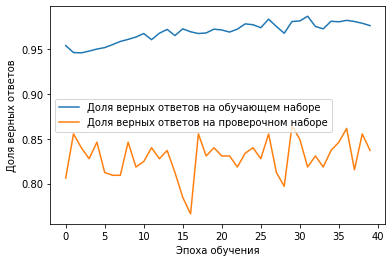

In [ ]:
# Так же можно посмотрим как сеть обучалась на графиках.

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

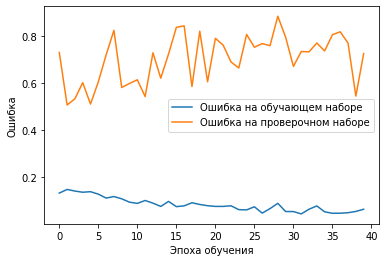

In [ ]:
# График ошибок. На предмет переобучения сети.
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show() 

**Попробуем добиться лучших результатов с помощью изменения различных гиперпараметров. Создадим новую нейронную сеть**.

In [ ]:
# По той же аналогии, первый раз обучаем сеть с шагом lr = 0.001 
model = Sequential()

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(img_width, img_height, 3)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.15))

model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.15))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.15))

model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.15))

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(2000, activation='relu'))
model.add(Dense(5000, activation='relu'))

model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [ ]:
# Снова компилируем и обучаем с lr=0.0001
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [ ]:
# Результат после двух обучений состоящим из 40 эпох каждый. 
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=40,
    verbose=1
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
123/123 [==============================] - 31s 248ms/step - loss: 0.2905 - accuracy: 0.8915 - val_loss: 0.3980 - val_accuracy: 0.8492
Epoch 2/40
123/123 [==============================] - 30s 245ms/step - loss: 0.2669 - accuracy: 0.8946 - val_loss: 0.4605 - val_accuracy: 0.8431
Epoch 3/40
123/123 [==============================] - 30s 246ms/step - loss: 0.2559 - accuracy: 0.9027 - val_loss: 0.4872 - val_accuracy: 0.8215
Epoch 4/40
123/123 [==============================] - 30s 246ms/step - loss: 0.2224 - accuracy: 0.9173 - val_loss: 0.5360 - val_accuracy: 0.8369
Epoch 5/40
123/123 [==============================] - 30s 245ms/step - loss: 0.2547 - accuracy: 0.8966 - val_loss: 0.5282 - val_accuracy: 0.8277
Epoch 6/40
123/123 [==============================] - 30s 245ms/step - loss: 0.2346 - accuracy: 0.9185 - val_loss: 0.4655 - val_accuracy: 0.8246
Epoch 7/40
123/123 [==============================] - 30s 244ms/step - loss: 0.2163 - accuracy: 0.9104 - val_loss: 0.5255 - val_ac

**Ура! На многих эпохах видно, что процент точности больше 85%. Можно сохранить полученный результат**. 

In [ ]:
model.save_weights('model - loss: 0.1281 - accuracy: 0.9540 - val_loss: 0.6415 - val_accuracy: 0.8738.h5')

In [ ]:
# Раз результат сохранен можно эксперементировать дальше и попробовать снова продолжить обучать, но уже с шагом lr=0.00001.
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

In [ ]:
# Обучения в третий раз lr=0.00001, 40 эпох. Всего за 3 обучения (120 эпох)
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=40,
    verbose=1
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
109/109 [==============================] - 32s 284ms/step - loss: 0.1131 - accuracy: 0.9562 - val_loss: 0.3633 - val_accuracy: 0.9052
Epoch 2/40
109/109 [==============================] - 30s 270ms/step - loss: 0.0755 - accuracy: 0.9741 - val_loss: 0.3104 - val_accuracy: 0.9156
Epoch 3/40
109/109 [==============================] - 30s 271ms/step - loss: 0.1095 - accuracy: 0.9621 - val_loss: 0.4650 - val_accuracy: 0.8978
Epoch 4/40
109/109 [==============================] - 30s 273ms/step - loss: 0.0964 - accuracy: 0.9613 - val_loss: 0.3181 - val_accuracy: 0.9141
Epoch 5/40
109/109 [==============================] - 30s 278ms/step - loss: 0.0785 - accuracy: 0.9695 - val_loss: 0.3585 - val_accuracy: 0.9052
Epoch 6/40
109/109 [==============================] - 30s 276ms/step - loss: 0.1032 - accuracy: 0.9603 - val_loss: 0.3138 - val_accuracy: 0.9185
Epoch 7/40
109/109 [==============================] - 30s 277ms/step - loss: 0.1067 - accuracy: 0.9598 - val_loss: 0.3341 - val_ac

In [ ]:
model.save_weights('model - loss: 0.0849 - accuracy: 0.9679 - val_loss: 0.3148 - val_accuracy: 0.9259.h5')

Лучший результат на 28 эпохе : loss: 0.0875 - accuracy: 0.9648 - val_loss:**0.2862** - val_accuracy: **0.9274**

**Можно сохранить веса на данной эпохе**.

## Выводы: 


- Добиться такого показателя было не просто. Очень много вариантов перепробовано и обучено. В большинстве своем точность не привышала 75%.
- Добавление различных слоев как увеличивало процент ошибки, так и уменьшала ее. 
 - Такой же эффект наблюдался при изменении количества нейронов, ядер свертки и размера ядра свертки у слоя Conv2D, изменения парметров у слоя MaxPooling2D.
 - Добавление на вход слоя BatchNormalization уменьшала точность и увеличивала ошибку. Но при использовании в дальнейшем давало результаты выше, чем без этого слоя. 
 - Параметр у слоя Dropout тоже подбирался. Оптимальное в данном случае значение оказалось равное 0.15
 - Изменение входных картинок по ширине и высоте (количество пикселей, тоже повлияло в лучшую сторону). Процент точности вырос. 
  - Так же были изменены параметры в функции ImageDataGenerator.
  - Можно и дальше пробовать изменять гиперпараметры нейронной сети добиваясь лучшего результата. 
  - Но в связи с маленькой базой, следует в дальнейшем увеличить ее, для большей точности предсказаний нейронной сети. 
  